In [117]:
#import investpy as inv
#[Referencia](https://www.youtube.com/watch?v=JmpZQAIDboo)
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm
from datetime import datetime

pd.options.mode.chained_assignment = None 

Ref: https://www.tesourodireto.com.br/titulos/historico-de-precos-e-taxas.htm

In [129]:
def get_bonds(prod_code: str, ref_year: int):
    assert prod_code in ('LTN', 'NTN-F', 'NTN-B')

    float_cols = ['Taxa Compra Manhã', 'Taxa Venda Manhã', 'PU Compra Manhã', 'PU Venda Manhã', 'PU Base Manhã']
    prod = prod_code 
    ref = ref_year 

    file = f'https://cdn.tesouro.gov.br/sistemas-internos/apex/producao/sistemas/sistd/{ref}/{prod}_{ref}.xls'

    df_list = pd.read_excel(file, sheet_name=None)
    
    clean_dfs = []
    for _, df in df_list.items():
        expiry = pd.to_datetime(df.columns[1])
        df.columns = df.iloc[0]
        df = df.iloc[1:]
        df['Dia'] = pd.to_datetime(df['Dia'], format='%d/%m/%Y')
        for col in float_cols:
            df[col] = df[col].astype(float)
        df['Expiry'] = expiry
        df['RefYear'] = ref
        clean_dfs.append(df)

    return pd.concat(clean_dfs)

# Fazer curvas para 2020

In [130]:
zcb_2020 = get_bonds('LTN', 2020) # LTNs sao zero-coupon bonds com par 1000

LTN tem par value R$ 1000

In [132]:
def yield_ltn_years_df(t: pd.Series, T: pd.Series, price: pd.Series):
    dt_years = (T - t).dt.days/365
    return -1.0/dt_years * np.log(price/1000.0)

In [142]:
zcb_2020['YTM'] = yield_ltn_years_df(zcb_2020['Dia'], 
                                     zcb_2020['Expiry'],
                                     zcb_2020['PU Venda Manhã'])
zcb_2020['tenor'] = (zcb_2020['Expiry'] - zcb_2020['Dia']).dt.days/365.0

In [143]:
aux = zcb_2020[zcb_2020['Dia'] == '2020-01-03']
display(aux)

,Dia,Taxa Compra Manhã,Taxa Venda Manhã,PU Compra Manhã,PU Venda Manhã,PU Base Manhã,Expiry,RefYear,YTM,tenor
2,2020-01-03,0.0453,0.0465,957.16,956.08,955.91,2021-01-01,2020,0.045037,0.99726
2,2020-01-03,0.0529,0.0541,902.77,900.74,900.55,2022-01-01,2020,0.052341,1.99726
2,2020-01-03,0.0584,0.0596,844.38,841.53,841.34,2023-01-01,2020,0.057564,2.99726
2,2020-01-03,0.0646,0.0658,732.34,728.24,728.06,2025-01-01,2020,0.063425,5.00000


In [178]:
time_range = pd.date_range(start='2020-01-02', end='2020-12-31', freq='14D')

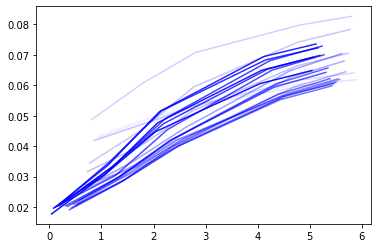

In [179]:
fig, ax = plt.subplots()
imax = len(time_range)
for i, dia in enumerate(time_range):
    dia_str = dia.strftime('%Y-%m-%d') 
    aux = zcb_2020[zcb_2020['Dia'] == dia_str]
    ax.plot(aux['tenor'], aux['YTM'], color='blue', alpha=i/imax)

# Para vários anos

In [180]:
zcbs = []
for year in tqdm(range(2010, 2023)):
    zcb = get_bonds('LTN', year)
    zcb['YTM'] = yield_ltn_years_df(zcb['Dia'], 
                                     zcb['Expiry'],
                                     zcb['PU Venda Manhã'])
    zcb['tenor'] = (zcb['Expiry'] - zcb['Dia']).dt.days/365.0
    zcbs.append(zcb)

  0%|          | 0/13 [00:00<?, ?it/s]

In [181]:
zcbs_df = pd.concat(zcbs)

In [183]:
zcbs_df.to_parquet('../_data/bonds.pqt')

# Visualizing 

In [210]:
dates = sorted(zcbs_df['Dia'].unique())

In [249]:
selic = pd.read_parquet('../_data/selic.pqt')

<IPython.core.display.Javascript object>


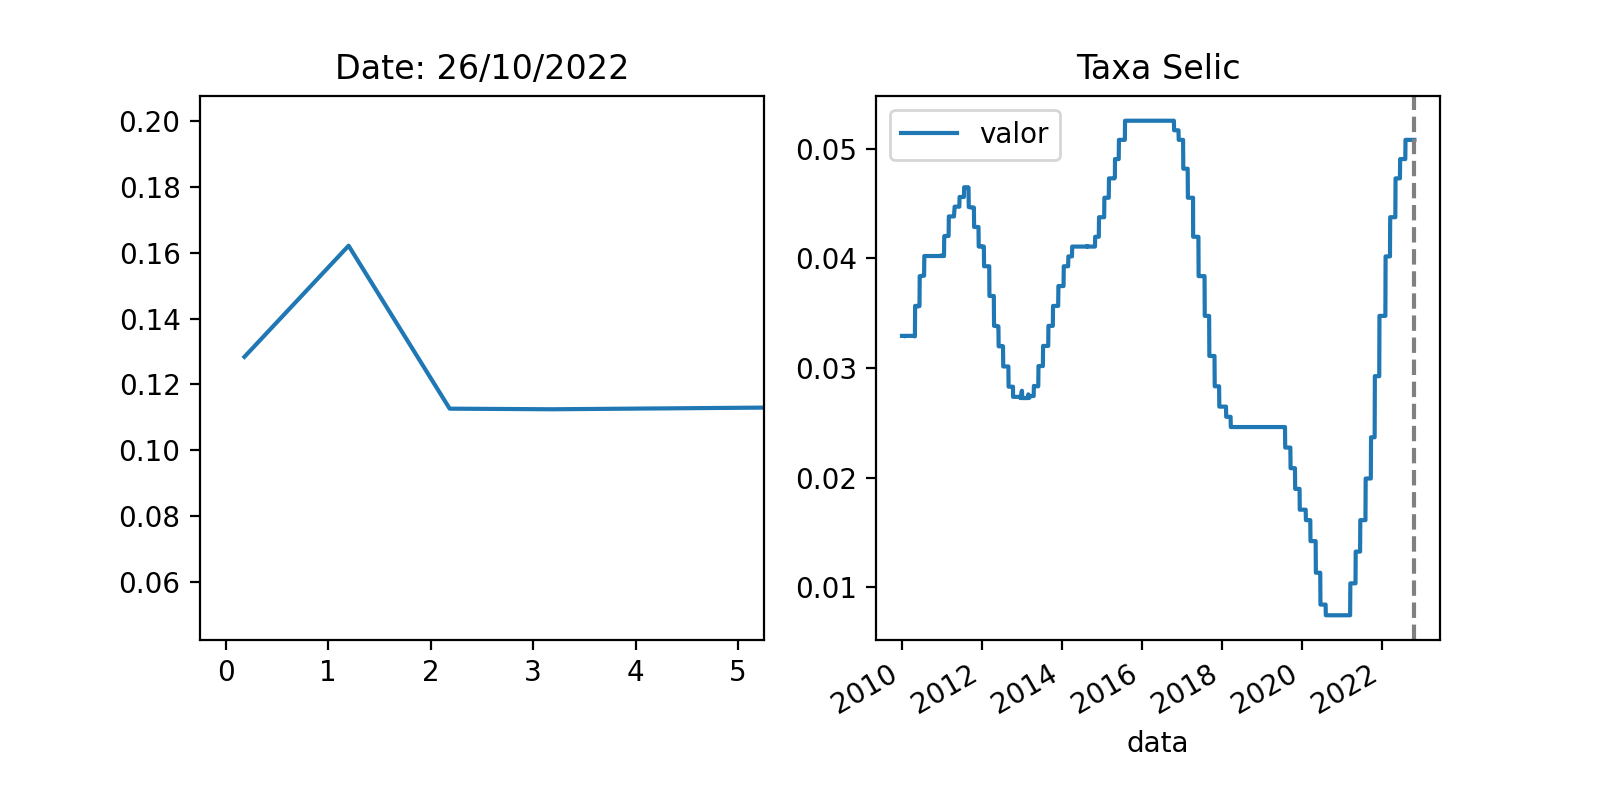

interactive(children=(IntSlider(value=10, description='i', max=3195), Output()), _dom_classes=('widget-interac…

In [266]:
from ipywidgets import interact

fig, ax = plt.subplots(ncols=2, figsize=(8,4))
x = np.linspace(0,5)
y = np.linspace(0.05,0.2)
line, = ax[0].plot(x,y)
selic.plot(ax=ax[1])

selic_line = ax[1].axvline(dates[0], color='gray', linestyle='--')
ax[1].set_title("Taxa Selic")

def update(i):
    aux = zcbs_df[zcbs_df['Dia'] == dates[i]].set_index('tenor')['YTM']
    x, y = aux.index.to_series(), aux.values 
    line.set_xdata(x)
    line.set_ydata(y)
    ax[0].set_title(f"Date: {pd.to_datetime(dates[i]).strftime('%d/%m/%Y')}")

    if dates[i] in selic.index: 
        selic_line.set_xdata(pd.to_datetime(dates[i]))

    fig.canvas.draw_idle()

interact(update, i=widgets.IntSlider(min=0, max=len(dates)-1, step=1, value=10));